# StyleGan Results

Below are fingings from running batchjobs using [stylgan2-ada-pytorch](https://github.com/NVlabs/stylegan2-ada-pytorch)'s generator. This experiment was run on machines with different GPUs to analyze the carbon footprint of generating images with the model. Our model is generating images from within the library. The finding of this experiment could be extrapolated past generating images to generating video ina naive way.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Understanding the data

Now that we've got some data loaded, let's see what codecarbon provides.

In [2]:
csv_files = []

for root, dirs, files in os.walk("."):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

# Load all CSVs into one DataFrame
df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

In [3]:
print(str(len(df)) + " experiments run.")

1244 experiments run.


In [4]:
df.columns

Index(['timestamp', 'project_name', 'run_id', 'duration', 'emissions',
       'emissions_rate', 'cpu_power', 'gpu_power', 'ram_power', 'cpu_energy',
       'gpu_energy', 'ram_energy', 'energy_consumed', 'country_name',
       'country_iso_code', 'region', 'cloud_provider', 'cloud_region', 'os',
       'python_version', 'codecarbon_version', 'cpu_count', 'cpu_model',
       'gpu_count', 'gpu_model', 'longitude', 'latitude', 'ram_total_size',
       'tracking_mode', 'on_cloud', 'pue', 'experiment_id'],
      dtype='object')

In [5]:
df["gpu_model"].value_counts()

1 x NVIDIA A100 80GB PCIe    341
4 x Tesla V100-PCIE-32GB     200
3 x Tesla V100-PCIE-32GB     200
2 x Tesla V100-PCIE-32GB     200
1 x Tesla V100-PCIE-32GB     109
1 x Tesla P100-PCIE-16GB     100
Apple M1 Pro                  63
Name: gpu_model, dtype: int64

In [6]:
# M1 pro is my laptop... dropping those from the dataframe
df = df[df["gpu_model"] != "Apple M1 Pro"]
df["gpu_model"].value_counts()

1 x NVIDIA A100 80GB PCIe    341
4 x Tesla V100-PCIE-32GB     200
3 x Tesla V100-PCIE-32GB     200
2 x Tesla V100-PCIE-32GB     200
1 x Tesla V100-PCIE-32GB     109
1 x Tesla P100-PCIE-16GB     100
Name: gpu_model, dtype: int64

In [7]:
all_v100 = df[df["gpu_model"].str.contains("V100", case=False, na=False)]
all_v100["gpu_model"].value_counts()

4 x Tesla V100-PCIE-32GB    200
3 x Tesla V100-PCIE-32GB    200
2 x Tesla V100-PCIE-32GB    200
1 x Tesla V100-PCIE-32GB    109
Name: gpu_model, dtype: int64

# Codecarbon

Some interseting data could be the emissions rate 

# V100 Investigation

/Users/dParris/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


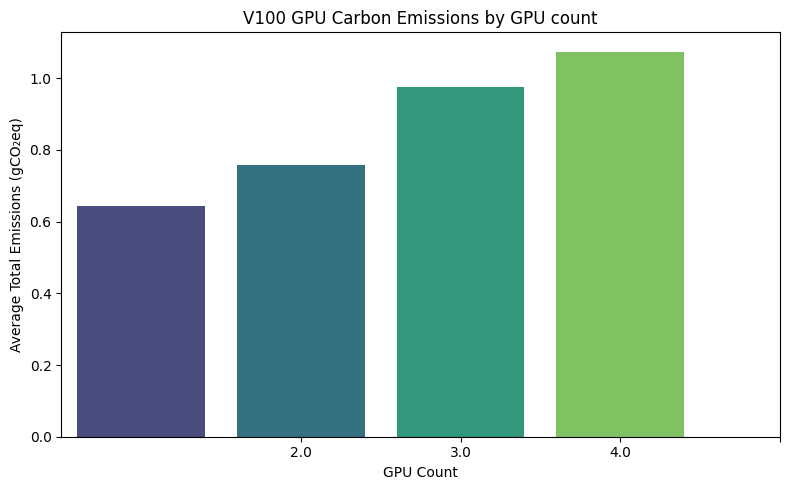

In [27]:
plt.figure(figsize=(8, 5))
v100_emissions_by_gpu = all_v100.groupby("gpu_count")["gpu_model", "emissions"].mean().reset_index()
v100_emissions_by_gpu["emissions"] = v100_emissions_by_gpu["emissions"] * 1000
sns.barplot(data=v100_emissions_by_gpu, x="gpu_count", y="emissions", palette="viridis")
plt.xlabel("GPU Count")
plt.xticks(v100_emissions_by_gpu["gpu_count"])
plt.ylabel("Average Total Emissions (gCO₂eq)")
plt.title("V100 GPU Carbon Emissions by GPU count")
plt.tight_layout()
plt.show()

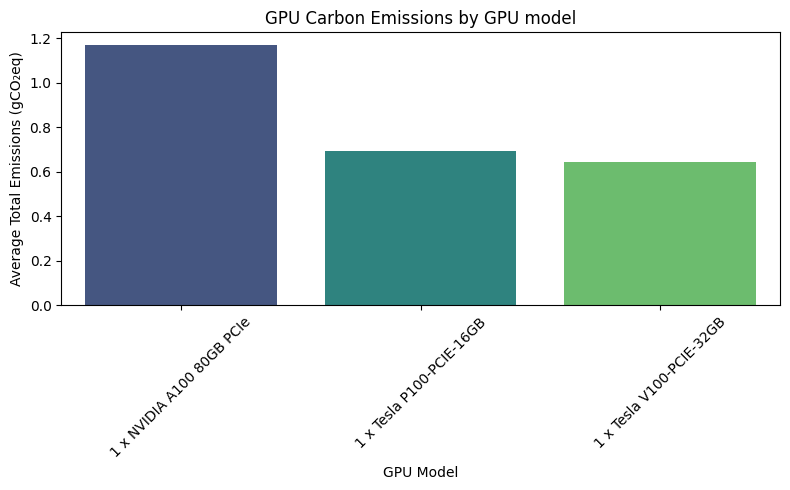

In [29]:
emissions = df[df["gpu_count"] == 1].groupby("gpu_model")["emissions"].mean().reset_index()
emissions["emissions"] = emissions["emissions"] * 1000
plt.figure(figsize=(8, 5))
sns.barplot(data=emissions, x="gpu_model", y="emissions", palette="viridis")
plt.xlabel("GPU Model")
plt.xticks(rotation=45)
plt.ylabel("Average Total Emissions (gCO₂eq)")
plt.title("GPU Carbon Emissions by GPU model")
plt.tight_layout()
plt.show()

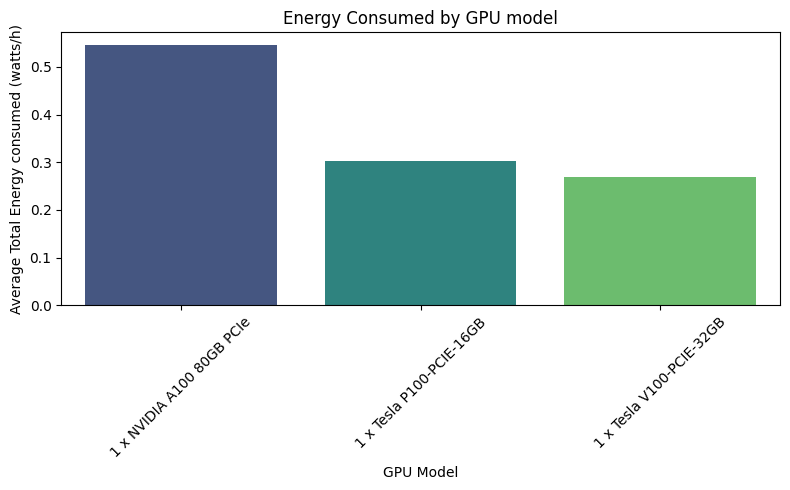

In [11]:
all_energy_by_single_gpu = df[df["gpu_count"] == 1].groupby("gpu_model")["gpu_energy"].mean().reset_index()
all_energy_by_single_gpu["gpu_energy"] = all_energy_by_single_gpu["gpu_energy"] * 1000
plt.figure(figsize=(8, 5))
sns.barplot(data=all_energy_by_single_gpu, x="gpu_model", y="gpu_energy", palette="viridis")
plt.xlabel("GPU Model")
plt.xticks(rotation=45)
plt.ylabel("Average Total Energy consumed (watts/h)")
plt.title("Energy Consumed by GPU model")
plt.tight_layout()
plt.show()

In [12]:
all_energy_by_single_gpu

,gpu_model,gpu_energy
0,1 x NVIDIA A100 80GB PCIe,0.545223
1,1 x Tesla P100-PCIE-16GB,0.301662
2,1 x Tesla V100-PCIE-32GB,0.269805


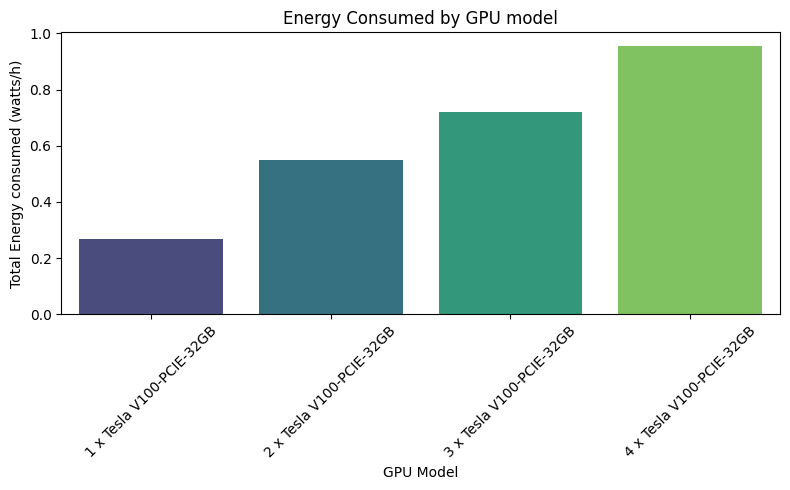

In [13]:
v100_energy = all_v100.groupby("gpu_model")["gpu_energy"].mean().reset_index()
v100_energy["gpu_energy"] = v100_energy["gpu_energy"] * 1000
plt.figure(figsize=(8, 5))
sns.barplot(data=v100_energy, x="gpu_model", y="gpu_energy", palette="viridis")
plt.xlabel("GPU Model")
plt.xticks(rotation=45)
plt.ylabel("Total Energy consumed (watts/h)")
plt.title("Energy Consumed by GPU model")
plt.tight_layout()
plt.show()

In [14]:
v100_energy

,gpu_model,gpu_energy
0,1 x Tesla V100-PCIE-32GB,0.269805
1,2 x Tesla V100-PCIE-32GB,0.550458
2,3 x Tesla V100-PCIE-32GB,0.719856
3,4 x Tesla V100-PCIE-32GB,0.955824


Seems like the 4 V100s consume more energy than the single A100 althought they emit similar anmounts of CO2

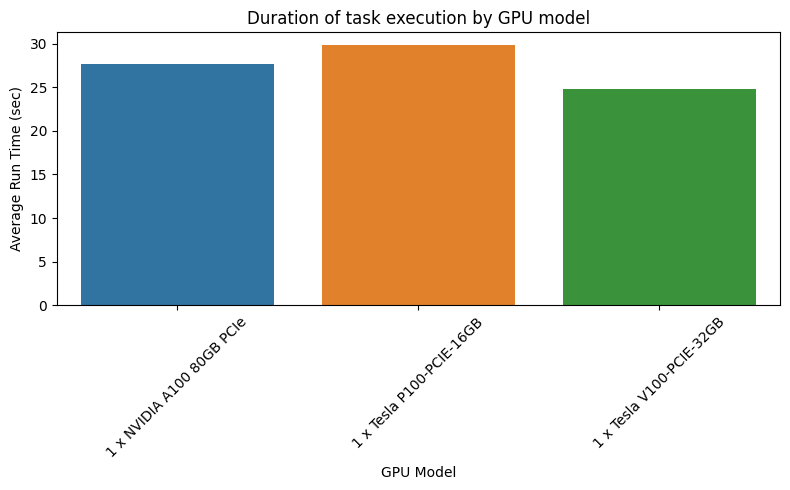

In [22]:
duration = df[df["gpu_count"] == 1].groupby("gpu_model")["duration"].mean().reset_index()
#all_energy_by_single_gpu["duration"] = all_energy_by_single_gpu["duration"] * 1000
plt.figure(figsize=(8, 5))
sns.barplot(data=duration, x="gpu_model", y="duration")
plt.xlabel("GPU Model")
plt.xticks(rotation=45)
plt.ylabel("Average Run Time (sec)")
plt.title("Duration of task execution by GPU model")
plt.tight_layout()
plt.show()

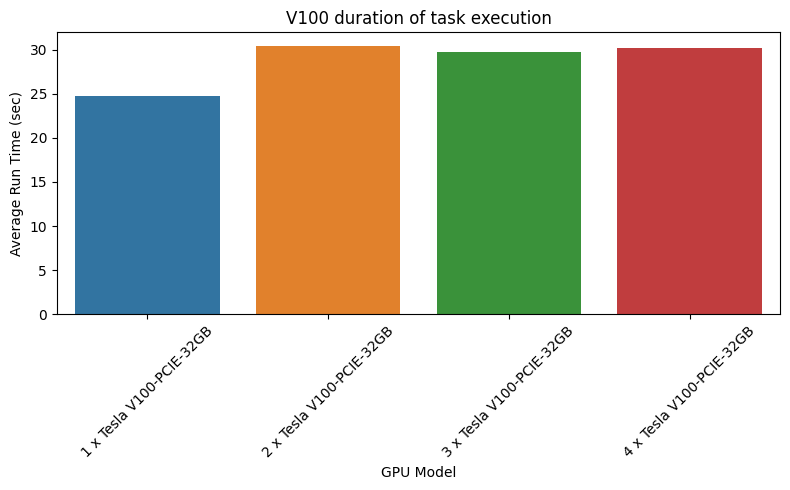

In [21]:
v100_duration = all_v100.groupby("gpu_model")["duration"].mean().reset_index()
#all_energy_by_single_gpu["duration"] = all_energy_by_single_gpu["duration"] * 1000
plt.figure(figsize=(8, 5))
sns.barplot(data=v100_duration, x="gpu_model", y="duration")
plt.xlabel("GPU Model")
plt.xticks(rotation=45)
plt.ylabel("Average Run Time (sec)")
plt.title("V100 duration of task execution")
plt.tight_layout()
plt.show()

In [20]:
pd.concat([duration, v100_duration], ignore_index=True)

,gpu_model,duration
0,1 x NVIDIA A100 80GB PCIe,27.676879
1,1 x Tesla P100-PCIE-16GB,29.802053
2,1 x Tesla V100-PCIE-32GB,24.785249
3,1 x Tesla V100-PCIE-32GB,24.785249
4,2 x Tesla V100-PCIE-32GB,30.427243
5,3 x Tesla V100-PCIE-32GB,29.679810
6,4 x Tesla V100-PCIE-32GB,30.141370


In [18]:
def plot(df, x, y, title):
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df, x=x, y=y, palette="viridis")
    plt.xlabel("GPU Model")
    plt.xticks(rotation=45)
    plt.ylabel("Average Run Time (sec)")
    plt.title("V100 duration of task execution")
    plt.tight_layout()
    plt.show()
    

In [31]:
df.to_csv("stylegan_codecarbon.csv", index=False)